# SciPy based transforms

In the last notebook `1_getting_started_with_robot_ik.ipynb` we have familiarized ourselves with the concept of Forward and Inverse Kinematics (IK) and implemented a simple IK solver for a 3DOF leg using trigonometry. In this notebook we will use SciPy to implement a more advanced IK solver.

SciPy, a Python library built upon NumPy, provides a wide array of mathematical algorithms and functions that are valuable for robotics, including linear algebra, which is of interest here.

The first step is to convert our forward kinematics code from custom Points and hand crafted function to use matrix transforms for rotation and translation.

Alongside the conversion, we are going to bring all the algorithms to work in full 3D space, not just 2D projections.

In [1]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

All cell outputs in this notebook are stripped from source code. To see the outputs, run the notebook locally or [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dr-QP/Dr.QP/blob/main/notebooks/2_affine_transforms.ipynb)

### Note for non default branch

If you are viewing non default branch change `--branch=main` below to branch name you are viewing.

## Runtime restart!!

The runtime need to be restarted to pick up the new modules. The code below will install them and kill runtime, simply run all cells again afterwards

In [2]:
# Setup for Google Colab
import importlib.util

IN_COLAB = (
    importlib.util.find_spec('google') is not None
    and importlib.util.find_spec('google.colab') is not None
)

if IN_COLAB:
    try:
        import plotting  # noqa: F401
        import point  # noqa: F401
    except ImportError:
        !git clone --filter=blob:none --no-checkout --depth 1 --sparse https://github.com/Dr-QP/Dr.QP.git --branch=main
        !cd Dr.QP && git sparse-checkout add notebooks && git checkout && cd ..
        !mv Dr.QP/notebooks/* .
        !mv Dr.QP/* .
        !rm -rf Dr.QP
        %pip install -r requirements.txt
        print('\n\n\nRestarting runtime to pick up the new modules...')
        import os

        os.kill(os.getpid(), 9)

In [ ]:
%matplotlib ipympl

import matplotlib.pyplot as plt

plt.ioff() # this is equivalent to using inline backend, but figures have to be displayed manually

In [4]:
import numpy as np
from point import Leg3D, Line3D, Point3D
from scipy.spatial.transform import Rotation as R


def forward_kinematics(
    coxa_length, femur_length, tibia_length, alpha, beta, gamma, start_height=2, body_length=5
):
    # Define initial points in local coordinates
    start_point = Point3D([0, start_height, 0])
    body_local = Point3D([body_length, 0, 0])
    coxa_local = Point3D([coxa_length, 0, 0])
    femur_local = Point3D([femur_length, 0, 0])
    tibia_local = Point3D([tibia_length, 0, 0])

    # Create rotation matrices
    rotation_axis = np.array([0, 0, 1])
    r_alpha = R.from_rotvec(rotation_axis * alpha, degrees=True)
    r_beta = R.from_rotvec(rotation_axis * beta, degrees=True)
    r_gamma = R.from_rotvec(rotation_axis * gamma, degrees=True)

    # Calculate global positions using transformations
    body_point = start_point + body_local

    # Apply alpha rotation to coxa
    coxa_rotated = r_alpha.apply(coxa_local.numpy())
    coxa_point = body_point + coxa_rotated

    # Apply alpha+beta rotation to femur
    r_alpha_beta = r_alpha * r_beta
    femur_rotated = r_alpha_beta.apply(femur_local.numpy())
    femur_point = coxa_point + femur_rotated

    # Apply alpha+beta+gamma rotation to tibia
    r_alpha_beta_gamma = r_alpha_beta * r_gamma
    tibia_rotated = r_alpha_beta_gamma.apply(tibia_local.numpy())
    tibia_point = femur_point + tibia_rotated

    # Set  Point labels for visualization
    body_point.label = rf'$\alpha$={alpha}°'
    coxa_point.label = rf'$\beta$={beta}°'
    femur_point.label = rf'$\gamma$={gamma}°'
    tibia_point.label = 'Foot'

    # Return lines connecting the points
    return Leg3D(
        [
            Line3D(start_point, body_point, 'Body'),
            Line3D(body_point, coxa_point, 'Coxa'),
            Line3D(coxa_point, femur_point, 'Femur'),
            Line3D(femur_point, tibia_point, 'Tibia'),
        ]
    )

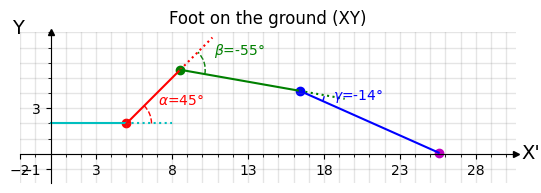

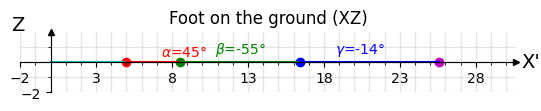

In [14]:
from plotting import plot_leg_with_points

coxa = 5
femur = 8
tibia = 10


model = forward_kinematics(coxa, femur, tibia, 45, -55, -14)

_ = plot_leg_with_points(
    model.xy, 'Foot on the ground (XY)', link_labels='none', x_label="X'", y_label='Y'
)
display(plt.gcf())

_ = plot_leg_with_points(
    model.xz, 'Foot on the ground (XZ)', link_labels='none', x_label="X'", y_label='Z'
)
display(plt.gcf())


This was a good start, but code is hard to read and understand due to excessive repetitions. Let's introduce a transform system, similar to the one used in ROS TF2 library.

With this `Transform` class we can now create a chain of transformations instead of hand crafting them.

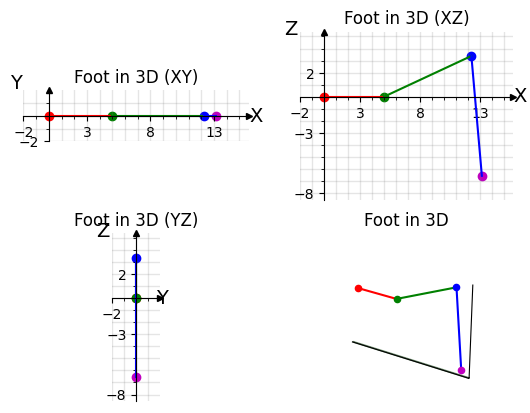

In [6]:
from plotting import plot_leg3d
from transforms import Transform


def forward_kinematics_transforms(
    coxa_length,
    femur_length,
    tibia_length,
    alpha,
    beta,
    gamma,
    leg_location_on_body=[0, 0, 0],
    leg_rotation=[0, 0, 0],
    body_transform=Transform.identity(),
    verbose=False,
):
    # Create rotation matrices and transforms
    body_link = body_transform @ Transform.from_translation(leg_location_on_body)
    body_joint = body_link @ Transform.from_rotvec(leg_rotation, degrees=True)

    coxa_joint = body_joint @ Transform.from_rotvec([0, 0, alpha], degrees=True)
    coxa_link = coxa_joint @ Transform.from_translation([coxa_length, 0, 0])

    femur_joint = coxa_link @ Transform.from_rotvec([0, beta, 0], degrees=True)
    femur_link = femur_joint @ Transform.from_translation([femur_length, 0, 0])

    tibia_joint = femur_link @ Transform.from_rotvec([0, gamma, 0], degrees=True)
    tibia_link = tibia_joint @ Transform.from_translation([tibia_length, 0, 0])

    # Calculate global positions using transformations
    identity_point = Point3D([0, 0, 0])

    body_start = body_transform.apply_point(identity_point)

    body_end = body_link.apply_point(identity_point)
    body_end.label = rf'$\alpha$={alpha}°'

    coxa_end = coxa_link.apply_point(identity_point)
    coxa_end.label = rf'$\beta$={beta}°'

    femur_end = femur_link.apply_point(identity_point)
    femur_end.label = rf'$\gamma$={gamma}°'

    tibia_end = tibia_link.apply_point(identity_point)
    tibia_end.label = 'Foot'

    result = Leg3D(
        [
            Line3D(body_start, body_end, 'Body'),
            Line3D(body_end, coxa_end, 'Coxa'),
            Line3D(coxa_end, femur_end, 'Femur'),
            Line3D(femur_end, tibia_end, 'Tibia'),
        ]
    )

    if verbose:
        print(f'{body_end=}')
        print(f'{coxa_end=}')
        print(f'{femur_end=}')
        print(f'{tibia_end=}')
        for line in result:
            print(line)

    return result


coxa = 5
femur = 8
tibia = 10

model = forward_kinematics_transforms(coxa, femur, tibia, 0, -25, 110)

fig, _, _, _ = plot_leg_with_points(
    model.xy,
    'Foot in 3D (XY)',
    link_labels='none',
    joint_labels='points',
    x_label='X',
    y_label='Y',
    subplot=221,
)
_ = plot_leg_with_points(
    model.xz,
    'Foot in 3D (XZ)',
    link_labels='none',
    joint_labels='points',
    x_label='X',
    y_label='Z',
    subplot=222,
    fig=fig,
)
_ = plot_leg_with_points(
    model.yz,
    'Foot in 3D (YZ)',
    link_labels='none',
    joint_labels='points',
    x_label='Y',
    y_label='Z',
    subplot=223,
    fig=fig,
)
_ = plot_leg3d(model, 'Foot in 3D', link_labels='none', joint_labels='points', subplot=224, fig=fig)
display(fig)
# print("foot position: ", model.lines[-1].end)

With full 3D kinematics model and plotting support lets setup a 6 legged robot.

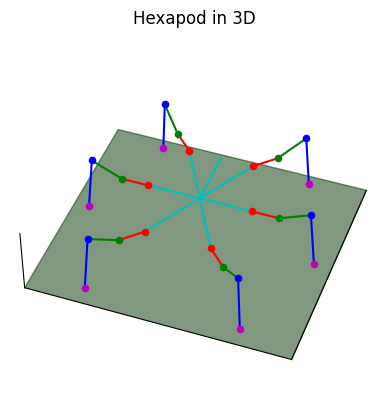

In [7]:
# Dr.QP Dimensions
from models import LegModel
from plotting import plot_update_leg3d_lines

drqp_front_offset = 0.116924  # x offset for the front and back legs
drqp_side_offset = 0.063871  # y offset fo the front and back legs
drqp_middle_offset = 0.103  # x offset for the middle legs

drqp_coxa = 0.053
drqp_femur = 0.066225
drqp_tibia = 0.123


class DrQP:
    def __init__(self, coxa_len=drqp_coxa, femur_len=drqp_femur, tibia_len=drqp_tibia):
        self.left_front_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='left_front',
            rotation=[0, 0, 45],
            location_on_body=[drqp_front_offset, drqp_side_offset, 0.0],
        )
        self.left_middle_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='left_middle',
            rotation=[0, 0, 90],
            location_on_body=[0.0, drqp_middle_offset, 0.0],
        )
        self.left_back_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='left_back',
            rotation=[0, 0, 135],
            location_on_body=[-drqp_front_offset, drqp_side_offset, 0.0],
        )

        self.right_front_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='right_front',
            rotation=[0, 0, -45],
            location_on_body=[drqp_front_offset, -drqp_side_offset, 0.0],
        )
        self.right_middle_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='right_middle',
            rotation=[0, 0, -90],
            location_on_body=[0.0, -drqp_middle_offset, 0.0],
        )
        self.right_back_leg = LegModel(
            coxa_len,
            femur_len,
            tibia_len,
            label='right_back',
            rotation=[0, 0, -135],
            location_on_body=[-drqp_front_offset, -drqp_side_offset, 0.0],
        )
        self.update_head()

    def forward_kinematics(self, alpha, beta, gamma):
        for leg in self.legs:
            leg.forward_kinematics(alpha, beta, gamma)

    @property
    def legs(self):
        return [
            self.left_front_leg,
            self.left_middle_leg,
            self.left_back_leg,
            self.right_front_leg,
            self.right_middle_leg,
            self.right_back_leg,
        ]

    @property
    def body_transform(self):
        return self.left_front_leg.body_transform

    @body_transform.setter
    def body_transform(self, value):
        for leg in self.legs:
            leg.body_transform = value

        self.update_head()

    def update_head(self):
        # Head, x-forward
        self.head = Line3D(
            self.body_transform.apply_point(Point3D([0, 0, 0])),
            self.body_transform.apply_point(Point3D([drqp_front_offset, 0, 0])),
            'Head',
        )


def plot_drqp(drqp, targets=None):
    fig, ax = None, None

    class PlotData:
        def __init__(self):
            self.leg_lines = []
            self.leg_joints = []
            self.head_line = None

    plot_data = PlotData()

    for leg in drqp.legs:
        fig, ax, lines, joints = plot_leg3d(
            leg,
            'Hexapod in 3D',
            link_labels='none',
            joint_labels='points',
            subplot=111,
            fig=fig,
            ax=ax,
        )
        plot_data.leg_lines.append(lines)
        plot_data.leg_joints.append(joints)

    plot_data.head_line = ax.plot(*zip(drqp.head.start, drqp.head.end), 'c')[0]

    if targets:
        ax.scatter(
            *zip(*[target.numpy() for target in targets]), color='k', label='unreachable target'
        )

    ax.view_init(elev=44.0, azim=-160)
    return fig, ax, plot_data


def update_drqp_plot(drqp, plot_data):
    for leg, lines, joints in zip(drqp.legs, plot_data.leg_lines, plot_data.leg_joints):
        plot_update_leg3d_lines(leg, lines, joints)

    if plot_data.head_line:
        plot_data.head_line.set_data_3d(*zip(drqp.head.start, drqp.head.end))


drqp = DrQP()
drqp.forward_kinematics(0, -25, 110)
fig, ax, plot_data = plot_drqp(drqp)
display(fig)

With the ability to do forward kinematics for a full robot, we can now start to work on the inverse kinematics. 1_getting_started_with_robot_ik.ipynb notebook covers the full 3D case of a single leg IK, however it works in the leg's local coordinate frame. In order to use it for the full robot, each leg global target position needs to be converted to the leg's local coordinate frame. Since we used matrix transformations for the forward kinematics, we can use the inverse of the body transform to convert the global target to the local coordinate frame.

```python
    def to_local(self, point):
        return self.body_joint.inverse().apply_point(point)
```

Leg left_middle failed to reach Point3D(-0.0800, 0.3174, -0.0945, Unreachable target), ended at Point3D(-0.0768, 0.3088, -0.0896, Foot)
Leg left_back failed to reach Point3D(-0.2844, 0.2119, -0.0945, Unreachable target), ended at Point3D(-0.2806, 0.2086, -0.0917, Foot)
Leg right_middle failed to reach Point3D(-0.0800, -0.3174, -0.0945, Unreachable target), ended at Point3D(-0.0768, -0.3088, -0.0896, Foot)
Leg right_back failed to reach Point3D(-0.2844, -0.2119, -0.0945, Unreachable target), ended at Point3D(-0.2806, -0.2086, -0.0917, Foot)


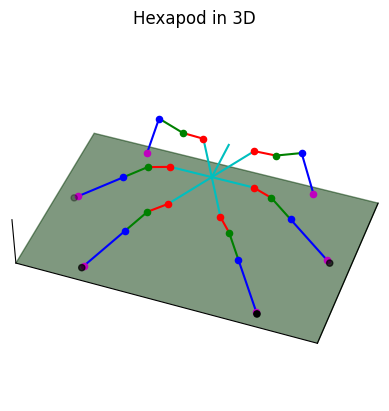

In [8]:
orig_alpha, orig_beta, orig_gamma = 0, -25, 110
drqp = DrQP()
drqp.forward_kinematics(orig_alpha, orig_beta, orig_gamma)

targets = []
for leg in drqp.legs:
    target = leg.tibia_end.copy()
    target.label = 'Target'
    target.x -= 0.08
    target.y *= 1.4

    reached = leg.move_to(target)
    if not reached:
        target.label = 'Unreachable target'
        targets.append(target)
        print(f'Leg {leg.label} failed to reach {target}, ended at {leg.tibia_end}')

fig, ax, plot_data = plot_drqp(drqp, targets)
display(fig)

With the ability to position all legs, its time to work on the inverse kinematics for the body. 

The algorithm is as follows:
 1. Capture the reference stance
    - Run forward kinematics for all legs with the same angles in a desired position (neutral, wide, narrow, specific gait). 
    - Capture global positions of all leg foot tips
 2. Apply transform to the robot's body (translation, rotation, twist).
 3. Run inverse kinematics for all legs with the foot positions captured in step 1.

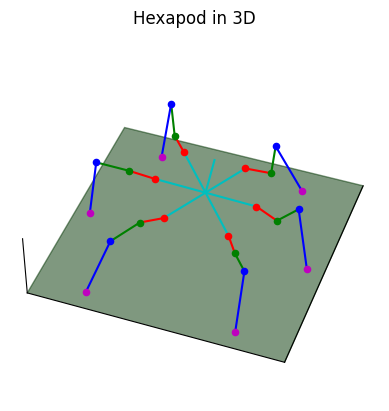

In [9]:
orig_alpha, orig_beta, orig_gamma = 0, -25, 110
drqp = DrQP()
drqp.forward_kinematics(orig_alpha, orig_beta, orig_gamma)

targets = [leg.tibia_end.copy() for leg in drqp.legs]

drqp.body_transform = Transform.from_translation([0.05, 0, -0.01]) @ Transform.from_rotvec(
    [10, 10, 10], degrees=True
)

unreachable_targets = []
for leg, target in zip(drqp.legs, targets):
    reached = leg.move_to(target)
    if not reached:
        target.label = 'Unreachable target'
        unreachable_targets.append(target)
        print(f'Leg {leg.label} failed to reach {target}, ended at {leg.tibia_end}')

fig, ax, plot_data = plot_drqp(drqp, unreachable_targets)
display(fig)

In [10]:
import math

steps = 64
x = 0.0
y = 0.0
z = 0.0
scalar = 0.05
sequence_xy_little_circle = [
    Transform.from_translation([x + math.cos(i) * scalar, y + math.sin(i) * scalar, z])
    for i in np.linspace(np.pi, np.pi * 3, steps)
]

sequence_xz_little_circle = [
    Transform.from_translation([x + math.sin(i) * scalar, y, z + math.cos(i) * scalar])
    for i in np.linspace(0, np.pi * 2, steps)
]

sequence_yz_little_circle = [
    Transform.from_translation([x, y + math.sin(i) * scalar, z + math.cos(i) * scalar])
    for i in np.linspace(0, np.pi * 2, steps)
]

sequence_xyz_little_circle = [
    Transform.from_translation(
        [x + math.cos(i) * scalar, y + math.sin(i) * scalar, z + math.cos(i) * scalar]
    )
    for i in np.linspace(0, np.pi * 2, steps)
]

In [11]:
# Plot IK solutions and targets into an animation

import matplotlib.animation
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.rcParams['animation.html'] = 'jshtml'

skip = True
interactive = False
was_interactive = plt.isinteractive()

def plot_mode():
  if interactive:
      return plt.ion()
  else:
      return plt.ioff()

try:
    if skip:
        raise KeyboardInterrupt

    orig_alpha, orig_beta, orig_gamma = 0, -25, 110
    drqp = DrQP()
    drqp.forward_kinematics(orig_alpha, orig_beta, orig_gamma)

    targets = [leg.tibia_end.copy() for leg in drqp.legs]

    transforms = [Transform.identity()]

    def interpolate(tf1: Transform, tf2: Transform, steps=10):
        interp_func = interp1d([0, steps], np.stack([tf1.matrix, tf2.matrix]), axis=0)
        for i in range(steps):
            transforms.append(Transform(interp_func(i)))

    def extend_transforms(ohter_transforms, steps=10):
        interpolate(transforms[-1], ohter_transforms[0], steps=steps)
        transforms.extend(ohter_transforms)

    def turn_transforms(axis, turn_degrees=10):
        axis = np.array(axis)
        for i in range(0, turn_degrees):
            transforms.append(Transform.from_rotvec(axis * i, degrees=True))

        for i in range(turn_degrees, -turn_degrees, -1):
            transforms.append(Transform.from_rotvec(axis * i, degrees=True))

        for i in range(-turn_degrees, 0):
            transforms.append(Transform.from_rotvec(axis * i, degrees=True))

    turn_transforms([0, 0, 1])
    turn_transforms([0, 1, 0])
    turn_transforms([1, 0, 0])
    turn_transforms([1, 1, 0])
    turn_transforms([1, 0, 1])
    turn_transforms([1, 1, 1])

    extend_transforms(sequence_xy_little_circle, steps=5)
    extend_transforms(sequence_xz_little_circle, steps=5)
    extend_transforms(sequence_yz_little_circle, steps=5)
    extend_transforms(sequence_xyz_little_circle, steps=5)

    # Close the loop
    interpolate(transforms[-1], transforms[0], steps=15)

    with plot_mode():
      fig, ax, plot_data = plot_drqp(drqp)

      def animate(frame):
          drqp.body_transform = transforms[frame]
          for leg, target in zip(drqp.legs, targets):
              leg.move_to(target)
          update_drqp_plot(drqp, plot_data)

      anim = FuncAnimation(fig, animate, frames=len(transforms), interval=20)

      save_animation = False
      if save_animation:
          animation_writer = matplotlib.animation.FFMpegWriter(fps=24)
          anim.save('animation.mp4', writer=animation_writer)

      if not interactive:
          display(anim)
except KeyboardInterrupt:
    print('Skipping animation')


Skipping animation


To make all the learnings and findings reusable in other notebooks, lets move all the code into modules and double check it works.

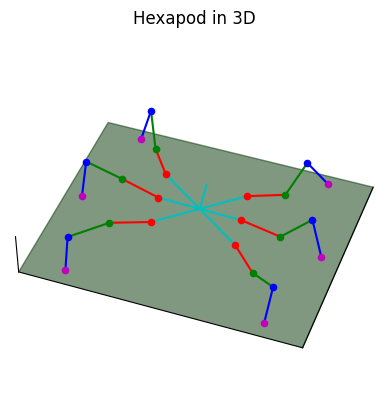

In [12]:
from models import HexapodModel
from plotting import plot_hexapod, update_hexapod_plot

hexapod = HexapodModel()
hexapod.forward_kinematics(0, -25, 110)
fig, ax, plot_data = plot_hexapod(hexapod)

leg_tips = [leg.tibia_end.copy() for leg in hexapod.legs]

hexapod.body_transform = Transform.from_translation([0.05, 0, -0.01]) @ Transform.from_rotvec(
    [10, 10, 10], degrees=True
)
hexapod.move_legs_to(leg_tips)
update_hexapod_plot(hexapod, plot_data)
display(fig)